# Supporting code and data for "..."

In [1]:
%matplotlib inline

import os
import sys
print(f'Python {sys.version}')

import IPython
from IPython.core.display import display, HTML
print(f'IPython {IPython.__version__}')

print('\nLibraries:\n')

import csv
print(f'csv {csv.__version__}')

import matplotlib
import matplotlib.pyplot as plt
print(f'matplotlib {matplotlib.__version__}')

import numpy as np
print(f'numpy {np.__version__}')

import pandas as pd
from pandas.plotting import register_matplotlib_converters
print(f'pandas {pd.__version__}')

import re
print(f're {re.__version__}')

import requests
print(f'requests {requests.__version__}')

#import scipy
#import scipy.stats
#print(f'scipy {scipy.__version__}')


#import statsmodels
#import statsmodels.formula.api as smf
#from statsmodels.stats.outliers_influence import summary_table
#print(f'statsmodels {statsmodels.__version__}')

Python 3.9.6 (default, Jun 28 2021, 08:57:49) 
[GCC 10.3.0]
IPython 7.24.1

Libraries:

csv 1.0
matplotlib 3.4.2
numpy 1.20.3
pandas 1.2.4
re 2.2.1
requests 2.25.1


## Data collection

We use the GitHub GraphQL API because it allows fetching only the information we need, and at a much faster rate (we can get up to 100 nodes in a single request). Getting all the objects of a certain type requires then to repeat the request to go through all the pages of results.

You need to provide a personal `api_token` if you want to get fresh data from GitHub. Otherwise, this notebook will skip the data collection step and load the CSV files from the local filesystem.

In [2]:
api_token = ''

In [3]:
def requestAllPages(query,rows_and_next_variables,filename,columns):
  if api_token == '':
    return
  headers = {'Authorization': f'token {api_token}'}
  url = 'https://api.github.com/graphql'
  rows, variables = rows_and_next_variables(None)
  while len(variables)>0:
    json = {'query':query,'variables':variables.pop()}
    r = requests.post(url=url, json=json, headers=headers)
    if r.status_code == 403:
      print('Unauthorized request:')
      print(json)
    r.raise_for_status() # Abort if unsuccessful request
    new_rows, next_variables = rows_and_next_variables(r.json()['data'])
    rows += new_rows
    variables += next_variables
  if len(rows) > 0:
    with open(filename, 'w') as f:
      writer = csv.writer(f)
      writer.writerow(columns)
      writer.writerows(rows)

We look for all the pull requests where the bot has proposed to minimize the CI failures. We get them by searching for the words "coqbot ci minimize".
This query is redundant with the next one, but useful if one only wants the list of PRs.
Uncomment the last line and make sure to provide an `api_token` to run it.

In [4]:
def fetch_prs():

  query = """
    query getPullRequestList($cursor: String) {
      search(query: "repo:coq/coq coqbot ci minimize", type:ISSUE, first: 100, after: $cursor) {
        nodes {
          ... on PullRequest {
            number
          }
        }
        pageInfo {
          hasNextPage
          endCursor
        }
      }
    }
  """

  def rows_and_next_variables(data):
    if data is None:
      return [], [{}]
    else:
      rows = []
      pullRequests = data['search']
      for node in pullRequests['nodes']:
        if 'number' in node:
            rows.append([node['number']])
      if pullRequests['pageInfo']['hasNextPage']:
        return rows, [{'cursor':pullRequests['pageInfo']['endCursor']}]
      else:
        return rows, []

  requestAllPages(
      query,
      rows_and_next_variables,
      'pullrequests.csv',
      ['number']
  )

# fetch_prs()

Here, we search again for all PRs where CI minimization was proposed but we retrieve all the comments to know what happened. Uncomment the last line and make sure to provide an `api_token` to re-run this.

In [5]:
def fetch_pr_comments():

  query = """
    query commentQuery($number: Int!, $single: Boolean!, $prCursor: String, $commentCursor: String) {
      search(query: "repo:coq/coq coqbot ci minimize", type:ISSUE, first: 10, after: $prCursor) @skip (if: $single) {
        pageInfo {
          endCursor
          hasNextPage
        }
        nodes {
          ... pullRequest
        }
      }
      repository(owner: "coq", name: "coq") @include (if: $single) {
        pullRequest(number: $number) {
          ... pullRequest
        }
      }
    }

    fragment pullRequest on PullRequest {
      number
      author { login }
      comments(first: 50, after: $commentCursor) {
        pageInfo {
          endCursor
          hasNextPage
        }
        nodes {
          createdAt
          author { login }
          bodyText
        }
      }
    }
  """

  def treat_pr(pr):
    rows, variables = [], []
    number = pr['number']
    pr_author = pr['author']['login']
    for comment in pr['comments']['nodes']:
      date = pd.to_datetime(comment['createdAt']).tz_localize(None)
      body = comment['bodyText'][:500].replace('\n','\\n')
      rows.append([number,pr_author,date,comment['author']['login'],body])
    if pr['comments']['pageInfo']['hasNextPage']:
      variables += [{
          'single':True,
          'number':number,
          'commentCursor':pr['comments']['pageInfo']['endCursor']
      }]
    return rows, variables

  def rows_and_next_variables(data):
    if data is None:
      return [], [{'single':False,'number':0}]
    else:
      if 'search' in data:
        prs = data['search']
        rows, variables = [], []
        for pr in prs['nodes']:
          if 'number' in pr:
            new_rows, new_variables = treat_pr(pr)
            rows += new_rows
            variables += new_variables
        if prs['pageInfo']['hasNextPage']:
          variables += [{
              'single':False,
              'number':0,
              'prCursor':prs['pageInfo']['endCursor']
          }]
        return rows, variables
      else:
        return treat_pr(data['repository']['pullRequest'])

  requestAllPages(
      query,
      rows_and_next_variables,
      'pr_comments.csv',
      ['number','pr_author','date','author','body']
  )

# fetch_pr_comments()

## Data processing

In [6]:
def load_csv(filename):

  df = pd.read_csv(filename,parse_dates=True,index_col=2)
  print(f'File retrieved from local file system: {filename}')
  return df

In [7]:
pr_comments = load_csv('pr_comments.csv')

File retrieved from local file system: pr_comments.csv


Pre-processing: we exclude PRs opened by Jason Gross (mostly for testing the CI minimizer):

In [8]:
pr_comments = pr_comments[~ pr_comments['pr_author'].isin(['JasonGross'])]

Retrieve all comments that triggered the bug minimizer:

In [9]:
ci_minimize_comments = pr_comments[
    pr_comments['body'].str.contains('@coqbot:? [Cc][Ii][- ][Mm]inimize') &
    ~ pr_comments['author'].isin(['coqbot-app'])
  ].sort_values('number')
ci_minimize_comments

,number,pr_author,author,body
date,,,,
2021-07-25 16:58:40,11966,olaure01,olaure01,@coqbot ci minimize
2021-07-20 23:39:01,12493,ppedrot,JasonGross,Hopefully things work better this time @coqbot...
2021-06-19 19:57:50,12493,ppedrot,JasonGross,@coqbot ci minimize
2021-06-21 01:37:25,12512,ppedrot,JasonGross,@coqbot ci minimize
2021-08-31 21:07:07,12512,ppedrot,ppedrot,@coqbot ci minimize
...,...,...,...,...
2021-10-19 14:15:59,15048,SkySkimmer,SkySkimmer,@coqbot ci minimize hott
2021-10-19 15:59:15,15048,SkySkimmer,SkySkimmer,@coqbot ci minimize ci-hott ci-relation_algebra
2021-10-19 15:59:31,15048,SkySkimmer,SkySkimmer,@coqbot ci minimize ci-category_theory


In [10]:
ci_minimize_triggerers = ci_minimize_comments.drop_duplicates(subset=['number', 'author']).sort_values('pr_author')
ci_minimize_triggerers

,number,pr_author,author,body
date,,,,
2021-08-03 16:39:13,14740,Alizter,Zimmi48,This wasn't expected that this would break any...
2021-08-13 12:20:58,14777,Alizter,Alizter,@coqbot ci minimize
2021-10-19 14:15:59,15048,SkySkimmer,SkySkimmer,@coqbot ci minimize hott
2021-10-05 17:13:30,14986,SkySkimmer,SkySkimmer,@coqbot ci minimize
2021-10-09 01:37:39,14986,SkySkimmer,JasonGross,"I've hopefully fixed the import problem, let's..."
2021-06-10 17:23:25,14480,SkySkimmer,SkySkimmer,@coqbot ci minimize ci-iris
2021-06-29 19:42:28,13107,SkySkimmer,JasonGross,"Minimization of ci-perennial should work now, ..."
2021-08-11 21:54:13,14758,SkySkimmer,Alizter,@coqbot ci minimize
2021-08-14 11:39:06,14785,SkySkimmer,SkySkimmer,@coqbot ci minimize


Let's focus only on cases where the CI minimization did produce a minimized file:

In [11]:
ci_minimize_results = pr_comments[pr_comments['body'].str.contains('Minimized File') & pr_comments['author'].isin(['coqbot-app'])].sort_values('number')
ci_minimize_results

,number,pr_author,author,body
date,,,,
2021-07-25 17:04:47,11966,olaure01,coqbot-app,Minimized File /github/workspace/builds/coq/co...
2021-07-25 18:26:22,11966,olaure01,coqbot-app,Minimized File /github/workspace/builds/coq/co...
2021-07-26 05:49:12,11966,olaure01,coqbot-app,Minimized File /github/workspace/builds/coq/co...
2021-07-25 22:15:29,11966,olaure01,coqbot-app,Minimized File /github/workspace/builds/coq/co...
2021-07-26 03:32:24,11966,olaure01,coqbot-app,Minimized File /github/workspace/builds/coq/co...
...,...,...,...,...
2021-10-05 22:30:22,14986,SkySkimmer,coqbot-app,Minimized File /github/workspace/builds/coq/co...
2021-10-09 22:45:58,14986,SkySkimmer,coqbot-app,Minimized File /github/workspace/builds/coq/co...
2021-10-19 16:12:59,15048,SkySkimmer,coqbot-app,Minimized File /github/workspace/builds/coq/co...


In [12]:
minimized_prs = ci_minimize_results['number'].drop_duplicates()
len(minimized_prs)

33

We call the following "successful triggerers" but this is an overapproximation as it suffices that the CI minimizer was triggered successfully once in the PR, and that could have been by someone else in case several persons were involved in triggering it:

In [13]:
successful_triggerers = ci_minimize_triggerers[ci_minimize_triggerers['number'].isin(minimized_prs)]
successful_triggerers

,number,pr_author,author,body
date,,,,
2021-08-03 16:39:13,14740,Alizter,Zimmi48,This wasn't expected that this would break any...
2021-08-13 12:20:58,14777,Alizter,Alizter,@coqbot ci minimize
2021-10-19 14:15:59,15048,SkySkimmer,SkySkimmer,@coqbot ci minimize hott
2021-10-05 17:13:30,14986,SkySkimmer,SkySkimmer,@coqbot ci minimize
2021-10-09 01:37:39,14986,SkySkimmer,JasonGross,"I've hopefully fixed the import problem, let's..."
2021-06-10 17:23:25,14480,SkySkimmer,SkySkimmer,@coqbot ci minimize ci-iris
2021-06-29 19:42:28,13107,SkySkimmer,JasonGross,"Minimization of ci-perennial should work now, ..."
2021-08-11 21:54:13,14758,SkySkimmer,Alizter,@coqbot ci minimize
2021-08-14 11:39:06,14785,SkySkimmer,SkySkimmer,@coqbot ci minimize


In [14]:
users_to_survey = list(np.unique(np.append(successful_triggerers['pr_author'],successful_triggerers['author'])))
users_to_survey.remove('JasonGross')
users_to_survey.remove('Zimmi48')
users_to_survey

['Alizter',
 'SkySkimmer',
 'ana-borges',
 'herbelin',
 'mattam82',
 'maximedenes',
 'mrhaandi',
 'olaure01',
 'ppedrot',
 'proux01']

In [15]:
len(users_to_survey)

10

In [16]:
def get_relevant_prs(user):
    return list(np.unique(successful_triggerers[successful_triggerers['pr_author'].isin([user]) | successful_triggerers['author'].isin([user])]['number']))

In [17]:
print("Hello, we (@JasonGross, @Zimmi48 and @achlipala) are trying to evaluate how useful the new CI minimization feature of coqbot is in practice. \
For that, we have created a very short survey (and most questions are optional) and we would appreciate if you could answer it *for each* pull request where the CI minimizer was used \
(that you authored or where you triggered the minimizer). Thanks a lot for your help!\n\nHere is a list of pull requests for which we would appreciate \
your answer to the survey:")

for user in users_to_survey:
    print(f'\n@{user}:\n')
    for pr in get_relevant_prs(user):
        print(f'- [ ] coq/coq#{pr} ([direct survey link](https://docs.google.com/forms/d/e/1FAIpQLSeWNKcF_XM0PPkydbvx4gaiKJFUG5xpMyewYK1dbtjAQt7FnQ/viewform?entry.155981120={pr}))')

Hello, we (@JasonGross, @Zimmi48 and @achlipala) are trying to evaluate how useful the new CI minimization feature of coqbot is in practice. For that, we have created a very short survey (and most questions are optional) and we would appreciate if you could answer it *for each* pull request where the CI minimizer was used (that you authored or where you triggered the minimizer). Thanks a lot for your help!

Here is a list of pull requests for which we would appreciate your answer to the survey:

@Alizter:

- [ ] coq/coq#14740 ([direct survey link](https://docs.google.com/forms/d/e/1FAIpQLSeWNKcF_XM0PPkydbvx4gaiKJFUG5xpMyewYK1dbtjAQt7FnQ/viewform?entry.155981120=14740))
- [ ] coq/coq#14758 ([direct survey link](https://docs.google.com/forms/d/e/1FAIpQLSeWNKcF_XM0PPkydbvx4gaiKJFUG5xpMyewYK1dbtjAQt7FnQ/viewform?entry.155981120=14758))
- [ ] coq/coq#14777 ([direct survey link](https://docs.google.com/forms/d/e/1FAIpQLSeWNKcF_XM0PPkydbvx4gaiKJFUG5xpMyewYK1dbtjAQt7FnQ/viewform?entry.15598112

## Survey analysis

In [18]:
survey = load_csv('survey.csv')
survey = survey.reset_index().set_index('Pull request number where the CI minimizer was used').sort_index()

File retrieved from local file system: survey.csv


In [19]:
survey

,Are you the author of the pull request?,Horodateur,Did you trigger the CI minimizer on this pull request yourself?,Is this the first time that you've used the CI minimizer?,Was the CI minimizer run on this pull request useful to you?,Did the output of the CI minimizer help you to understand the impact of the pull request on external projects?,(Before reading this question) did you use the output of the CI minimizer on this pull request to extend the test suite of Coq?,"If not, can you tell us why?",Do you have more feedback that you'd like to share with us?
Pull request number where the CI minimizer was used,,,,,,,,,
11966,Yes,2021/11/07 6:17:04 PM UTC+1,Yes,Yes,Not useful,No,No (and I didn't plan to do so),NaN,NaN
13107,Yes,2021/11/07 12:10:11 PM UTC+1,No,NaN,Not useful,No,No (and I didn't plan to do so),NaN,NaN
13895,Yes,2021/10/28 5:24:21 PM UTC+1,Yes,Yes,Not useful,No,No (and I didn't plan to do so),The output of the minimizer was too long and u...,I thought coqbot was too eager to remind us of...
13969,Yes,2021/11/03 4:48:02 PM UTC+1,Yes,Yes,Very useful,Yes,Yes,NaN,NaN
14480,Yes,2021/11/07 12:11:34 PM UTC+1,Yes,NaN,Somewhat useful,Yes,Yes,NaN,NaN
14612,Yes,2021/10/29 8:55:36 AM UTC+1,Yes,Yes,Very useful,Yes,Yes,NaN,The most impactful benefit of the minimizer fo...
14733,No,2021/11/07 12:12:29 PM UTC+1,Yes,No,Not useful,No,No (and I didn't plan to do so),NaN,NaN
14740,Yes,2021/10/29 12:44:13 AM UTC+1,No,No,Not useful,No,No (and I didn't plan to do so),"In this case, the CI errors were my fault and ...",NaN
14758,Yes,2021/11/07 12:13:44 PM UTC+1,No,NaN,Not useful,No,No (and I didn't plan to do so),NaN,NaN


In [20]:
self_triggerers = survey[survey['Did you trigger the CI minimizer on this pull request yourself?']=='Yes']
non_triggerers  = survey[survey['Did you trigger the CI minimizer on this pull request yourself?']=='No']

<AxesSubplot:ylabel='None'>

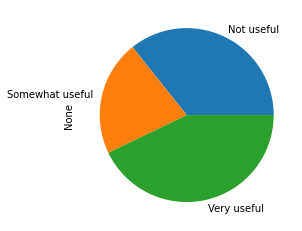

In [21]:
self_triggerers.groupby(['Was the CI minimizer run on this pull request useful to you?']).size().plot.pie()

<AxesSubplot:ylabel='None'>

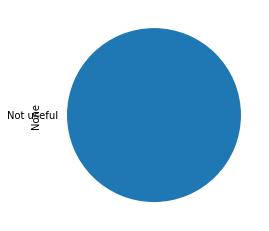

In [22]:
non_triggerers.groupby(['Was the CI minimizer run on this pull request useful to you?']).size().plot.pie()

In [23]:
self_triggerers[self_triggerers['Was the CI minimizer run on this pull request useful to you?'] == 'Not useful']

,Are you the author of the pull request?,Horodateur,Did you trigger the CI minimizer on this pull request yourself?,Is this the first time that you've used the CI minimizer?,Was the CI minimizer run on this pull request useful to you?,Did the output of the CI minimizer help you to understand the impact of the pull request on external projects?,(Before reading this question) did you use the output of the CI minimizer on this pull request to extend the test suite of Coq?,"If not, can you tell us why?",Do you have more feedback that you'd like to share with us?
Pull request number where the CI minimizer was used,,,,,,,,,
11966,Yes,2021/11/07 6:17:04 PM UTC+1,Yes,Yes,Not useful,No,No (and I didn't plan to do so),NaN,NaN
13895,Yes,2021/10/28 5:24:21 PM UTC+1,Yes,Yes,Not useful,No,No (and I didn't plan to do so),The output of the minimizer was too long and u...,I thought coqbot was too eager to remind us of...
14733,No,2021/11/07 12:12:29 PM UTC+1,Yes,No,Not useful,No,No (and I didn't plan to do so),NaN,NaN
14777,Yes,2021/10/29 12:51:19 AM UTC+1,Yes,No,Not useful,No,No (and I didn't plan to do so),In this case the minimizer wasn't able to mini...,NaN
14783,Yes,2021/11/07 12:15:05 PM UTC+1,Yes,No,Not useful,NaN,NaN,NaN,this PR changed the ci commit used so the mini...


In [24]:
self_triggerers_useful = self_triggerers[self_triggerers['Was the CI minimizer run on this pull request useful to you?'] != 'Not useful']
self_triggerers_useful

,Are you the author of the pull request?,Horodateur,Did you trigger the CI minimizer on this pull request yourself?,Is this the first time that you've used the CI minimizer?,Was the CI minimizer run on this pull request useful to you?,Did the output of the CI minimizer help you to understand the impact of the pull request on external projects?,(Before reading this question) did you use the output of the CI minimizer on this pull request to extend the test suite of Coq?,"If not, can you tell us why?",Do you have more feedback that you'd like to share with us?
Pull request number where the CI minimizer was used,,,,,,,,,
13969,Yes,2021/11/03 4:48:02 PM UTC+1,Yes,Yes,Very useful,Yes,Yes,NaN,NaN
14480,Yes,2021/11/07 12:11:34 PM UTC+1,Yes,NaN,Somewhat useful,Yes,Yes,NaN,NaN
14612,Yes,2021/10/29 8:55:36 AM UTC+1,Yes,Yes,Very useful,Yes,Yes,NaN,The most impactful benefit of the minimizer fo...
14758,No,2021/10/29 12:46:25 AM UTC+1,Yes,Yes,Very useful,Yes,Yes,NaN,Worked exactly as expected here.
14785,Yes,2021/11/07 12:16:16 PM UTC+1,Yes,NaN,Very useful,NaN,No (and I didn't plan to do so),NaN,NaN
14819,No,2021/10/29 12:48:53 AM UTC+1,Yes,No,Very useful,Yes,No (and I didn't plan to do so),"In this case, an external project was found to...","It quickly identified what the problem was, th..."
14929,No,2021/11/07 12:18:36 PM UTC+1,Yes,NaN,Somewhat useful,NaN,NaN,NaN,NaN
14986,Yes,2021/11/07 12:20:08 PM UTC+1,Yes,NaN,Somewhat useful,NaN,No (and I didn't plan to do so),NaN,NaN
15048,Yes,2021/11/07 12:21:11 PM UTC+1,Yes,NaN,Very useful,NaN,Yes,NaN,NaN


<AxesSubplot:ylabel='None'>

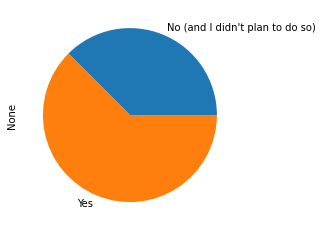

In [25]:
self_triggerers_useful.groupby(['(Before reading this question) did you use the output of the CI minimizer on this pull request to extend the test suite of Coq?']).size().plot.pie()

## Successful triggers analysis

In [26]:
ci_minimize_results['truncated'] = ci_minimize_results['body'].str.contains('truncated')

<AxesSubplot:ylabel='None'>

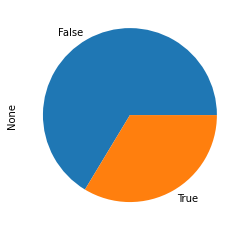

In [27]:
ci_minimize_results.groupby(['truncated']).size().plot.pie()